# Classifying cancer expression vectors

In this assignment you will train a neural network to identify the tissue type that produced an RNA expression vector. The dataset is comprised of RNA-seq data obtained from tumors. 

For a complete description of the data collection workflow see this page:
https://xenabrowser.net/datapages/?host=https://toil.xenahubs.net

And for the corresponding publication:
https://doi.org/10.1038/nbt.3772

In [15]:
import sys
import numpy as np
from matplotlib import pyplot
import pandas as pd
import h5py
import os
from sklearn.model_selection import StratifiedShuffleSplit
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F

print("USING pytorch VERSION: ", torch.__version__)

USING pytorch VERSION:  1.13.1+cu116


## Loading and parsing training data
For this problem, expression data needs to be loaded and pruned. Initially, there are >50,000 genes in each expression vector, which can be reduced to a much smaller gene set for the sake of minimizing computation time. Here, the data is subsetted to only include genes from the KEGG gene set. You may want to consider reducing or expanding this dataset to get a better understanding of which genes are predictive, though this is not a requirement for the assignment.

For a list of gene sets, check out the MSigDB collections page: http://software.broadinstitute.org/gsea/msigdb/collections.jsp

This script was adapted from Rob Currie's ingestion script: https://github.com/rcurrie/tumornormal/blob/master/genesets.ipynb

We have placed a subset of this data for this homework in Google drive, you can download it here:

https://drive.google.com/drive/folders/1pPABQDEHCddPTJAhfD6G5KyBDJiK3unQ?usp=sharing

In [16]:
# Load the data - If using Google drive link to access data the following with connect
# to drive, authenticate using your Google account and load the data

!pip install -U -q PyDrive ## you will have install for every colab session

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# x_test: https://drive.google.com/file/d/1Cc4zEw1wANFX8S44L87Rx_EZWwCcONMW/view?usp=sharing
# x_train: https://drive.google.com/file/d/1s8VvRaUc62OYukRunV689Y9u-v_y7KRl/view?usp=sharing
# y_test: https://drive.google.com/file/d/1W4Qdr3zm5QYGP5ncMQSurrO1m05KsKQ2/view?usp=sharing
# t_train: https://drive.google.com/file/d/1UmDZ25W84DmIY4im2XHCAc5QGgNkdexD/view?usp=sharing

# 2. Now proxy the Google Drive files to a local file
x_test_import = drive.CreateFile({'id':'1Cc4zEw1wANFX8S44L87Rx_EZWwCcONMW'})
x_train_import = drive.CreateFile({'id':'1s8VvRaUc62OYukRunV689Y9u-v_y7KRl'})
y_test_import = drive.CreateFile({'id':'1W4Qdr3zm5QYGP5ncMQSurrO1m05KsKQ2'})
y_train_import = drive.CreateFile({'id':'1UmDZ25W84DmIY4im2XHCAc5QGgNkdexD'})

x_test_import.GetContentFile('x_test.npz') # x_test.npz is the file name that will be accessible in the notebook.
x_train_import.GetContentFile('x_train.npz') # x_train.npz is the file name that will be accessible in the notebook.
y_test_import.GetContentFile('y_test.npz') # y_test.npz is the file name that will be accessible in the notebook.
y_train_import.GetContentFile('y_train.npz') # y_train.npz is the file name that will be accessible in the notebook.

y_index_key = {'Adipose Tissue': 0, 'Adrenal Gland': 1, 'Adrenal gland': 2, 'Bile duct': 3, 'Bladder': 4, 'Blood': 5, 'Blood Vessel': 6, 'Bone Marrow': 7, 'Brain': 8, 'Breast': 9, 'Cervix': 10, 'Cervix Uteri': 11, 'Colon': 12, 'Endometrium': 13, 'Esophagus': 14, 'Eye': 15, 'Fallopian Tube': 16, 'Head and Neck region': 17, 'Heart': 18, 'Kidney': 19, 'Lining of body cavities': 20, 'Liver': 21, 'Lung': 22, 'Lymphatic tissue': 23, 'Muscle': 24, 'Nerve': 25, 'Ovary': 26, 'Pancreas': 27, 'Paraganglia': 28, 'Pituitary': 29, 'Prostate': 30, 'Rectum': 31, 'Salivary Gland': 32, 'Skin': 33, 'Small Intestine': 34, 'Soft tissue,Bone': 35, 'Spleen': 36, 'Stomach': 37, 'SympatheticÊNervous System': 38, 'Testis': 39, 'Thymus': 40, 'Thyroid': 41, 'Thyroid Gland': 42, 'Uterus': 43, 'Vagina': 44, 'White blood cell': 45}

for name in y_index_key:
  print(name, y_index_key[name])

Adipose Tissue 0
Adrenal Gland 1
Adrenal gland 2
Bile duct 3
Bladder 4
Blood 5
Blood Vessel 6
Bone Marrow 7
Brain 8
Breast 9
Cervix 10
Cervix Uteri 11
Colon 12
Endometrium 13
Esophagus 14
Eye 15
Fallopian Tube 16
Head and Neck region 17
Heart 18
Kidney 19
Lining of body cavities 20
Liver 21
Lung 22
Lymphatic tissue 23
Muscle 24
Nerve 25
Ovary 26
Pancreas 27
Paraganglia 28
Pituitary 29
Prostate 30
Rectum 31
Salivary Gland 32
Skin 33
Small Intestine 34
Soft tissue,Bone 35
Spleen 36
Stomach 37
SympatheticÊNervous System 38
Testis 39
Thymus 40
Thyroid 41
Thyroid Gland 42
Uterus 43
Vagina 44
White blood cell 45


## Define a pytorch Dataset object to contain the training and testing data
Pytorch handles data shuffling and batch loading, as long as the user provides a "Dataset" class. This class is just a wrapper for your data that casts the data into pytorch tensor format and returns slices of the data. In this case, our data has been stored in numpy format, which conveniently pytorch has a method for converting to their native format.

In [17]:
class PrimarySiteDataset(Dataset):
    def __init__(self, x_path, y_path, batch_size=None):
        x = np.load(x_path)['a']
        y = np.load(y_path)['a']

        x_dtype = torch.FloatTensor
        y_dtype = torch.FloatTensor     # for MSE Loss

        self.length = x.shape[0]

        self.x_data = torch.from_numpy(x).type(x_dtype)
        self.y_data = torch.from_numpy(y).type(y_dtype)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.length


The ShallowLinear class inherits the pytorch.nn module attributes. This class defines the number of layers, the size of the layers, and the activation function. The method 'forward' takes in an input vector x which is sequentially operated on by the layers of the model. The training and testing method calls forward to calculate the model's output.

In [18]:

class ShallowLinear(nn.Module):
    '''
    A simple, general purpose, fully connected network
    '''
    def __init__(self):
        # Perform initialization of the pytorch superclass
        super(ShallowLinear, self).__init__()
        # Define network layer dimensions
        # D_in, H1, H2, D_out = [8, 5172, 5172, 46]    # These numbers correspond to each layer: [input, hidden_1, output]
        D_in = 5172   # input features
        H1 = 3000 # batch size
        H2 = 2000
        # H3 = 1000
        D_out = 46  # output
        # Define layer types
        # parameters associated with edges, not nodes
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)
        # self.linear4 = nn.Linear(H3, D_out)
        # self.linear2 = nn.Linear(H1, H2)
        # self.linear3 = nn.Linear(H2, D_out)  # added new hidden layer

    def forward(self, x):
        '''
        This method defines the network layering and activation functions
        '''
        # print("in forward beginning")
        
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        x = torch.relu(x)
        x = self.linear3(x)
        # x = torch.relu(x)
        # x = self.linear4(x)


        return x

The train_batch function trains the model with a training data by computing the forward pass, the calculation of loss with the 'loss_fn', and the updating of the parameters with the 'optimizer'.

'model' is the model that's getting trained.

'x' is the input data.

'y' is the output data.

'optimizer' is the optimizer object that updates the model parameters.

'loss_fn' is the loss function

This function outputs the loss value for the training data.

In [19]:
def train_batch(model, x, y, optimizer, loss_fn):
    ## Note, in practice pytorch can do this all for you in one step, but showing you here to be explicit
    
    # Run forward calculation
    y_predict = model.forward(x)

    # convert 1-hot vectors back into indices 
    max_values, target_index = y.max(dim=1) 
    target_index = target_index.type(torch.LongTensor)
    loss = loss_fn(y_predict, target_index)

    # loss = loss_fn(y_predict, y)

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable weights
    # of the model)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

    return loss.data.item()

The train function trains the model by calling the train_batch function.

'model' is the model being trained.

'loader' is the data loader for the inputs and outputs of the model.

'optimizer' is the optimizer object that updates the model parameters.

'loss_fn' is the loss function.

'epochs' is the amount of iterations through the training dataset.

This function returns all the losses.



In [20]:
def train(model, loader, optimizer, loss_fn, epochs=5):
    losses = list()

    batch_index = 0
    for e in range(epochs):
        for x, y in loader:

            loss = train_batch(model=model, x=x, y=y, optimizer=optimizer, loss_fn=loss_fn)

            losses.append(loss)

            batch_index += 1

        print("Epoch: ", e+1)
        print("Batches: ", batch_index)

    return losses

The test_batch function runs the forward calculation on the model.

'model' is the model to be tested.

'x' is the input data.

'y' is the output data.

This function returns the output data and the predicted output of the model.

In [21]:
def test_batch(model, x, y):
    # run forward calculation
    # print("x batch: ", x)
    y_predict = model.forward(x)
    # print("y_predict: ", y_predict)
    # print(y, y_predict)
    return y, y_predict

The test function uses a data loader from pytorch to check performance of the model.

'model' is the model to be tested.

'loader' is a data loader that holds the test data

This function outputs an array with predicted outputs of the model based on the test data.

In [22]:
def test(model, loader):
    y_vectors = list()
    y_predict_vectors = list()

    batch_index = 0
    for x, y in loader:
        # print("x: ", x)
        # print("y: ", y)
        y, y_predict = test_batch(model=model, x=x, y=y)
        # print("y, y_predict :", y[0], y_predict[0])
        y_truth = y
        print("y_predict y")
        for prediction in range(0, len(y_predict[0])):
            print(f"{y_predict[0][prediction]:.3f}", "   ", int(y[0][prediction].item()))        

        y_vectors.append(y.data.numpy())
        y_predict_vectors.append(y_predict.data.numpy())

        batch_index += 1

    y_predict_vector = np.concatenate(y_predict_vectors)

    return y_predict_vector, y_truth, y_predict

The plot_loss function plots the losses using matplotlib.

'losses' is a list of losses.

This function outputs a plot of the losses from the model.

In [23]:
def plot_loss(losses):
    fig = pyplot.gcf()
    fig.set_size_inches(8,6)
    ax = pyplot.axes()
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    x_loss = list(range(len(losses)))
    pyplot.plot(x_loss, losses)
    pyplot.show()
    pyplot.close()


The run function trains a model on a training dataset and then checks the performance of the model with the test dataset.

'dataset_train' contains the training data.

'dataset_test' contains the test data.

'batch_size_train' is the number of training examples used for training.

'n_epochs' is the number of iterations over the training set for training.

This function returns the loss values and the predicted outputs for the test data.

In [24]:
def run(dataset_train, dataset_test, batch_size_train = 80, n_epochs = 5):
    # Batch size is the number of training examples used to calculate each iteration's gradient
    
    
    data_loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size_train, shuffle=True)
    data_loader_test = DataLoader(dataset=dataset_test, batch_size=dataset_test.length, shuffle=False)
    
    # Define the hyperparameters
    learning_rate = 1e-2
    shallow_model = ShallowLinear()
    
    # Initialize the optimizer with above parameters
    # optimizer = optim.Adam(shallow_model.parameters(), lr=learning_rate)
    optimizer = optim.SGD(shallow_model.parameters(), lr=learning_rate)
    # Define the loss function
    # loss_fn = nn.MSELoss()  # mean squared error

    loss_fn = nn.CrossEntropyLoss()
    
    # Train and get the resulting loss per iteration
    loss = train(model=shallow_model, loader=data_loader_train, optimizer=optimizer, loss_fn=loss_fn, epochs=n_epochs)
    # print("hello")
    # Test and get the resulting predicted y values
    y_predict, y_truth, y_prediction = test(model=shallow_model, loader=data_loader_test)
    # highPredicts = np.empty((len(dataset_train[1][1]), 1))
    # highPredicts = []
    # for item in y_predict:
    #   highPredicts.append(np.argmax(y_predict[item]))
    # # highPredicts = np.argmax(y_predict)
    # # highYs = np.argmax(y)
    # highPredicts = np.array(highPredicts)
    # print("highPredicts: ", highPredicts)
    # print("shape of highPredicts: ", highPredicts.shape)
    # # print("shape of Ys: ", highYs.shape)

    return loss, y_predict, y_truth, y_prediction

example dataset


In [25]:
x_train_path = "x_train.npz"
y_train_path = "y_train.npz"
x_test_path = "x_test.npz"
y_test_path = "y_test.npz"
dataset_train = PrimarySiteDataset(x_path=x_train_path,
y_path=y_train_path)
dataset_test = PrimarySiteDataset(x_path=x_test_path,
y_path=y_test_path)

# print("Train set size: ", dataset_train.length)
# print("Test set size: ", dataset_test.length)

losses, y_predict, y_truth, y_prediction = run(dataset_train=dataset_train, dataset_test=dataset_test)


Epoch:  1
Batches:  192
Epoch:  2
Batches:  384
Epoch:  3
Batches:  576
Epoch:  4
Batches:  768
Epoch:  5
Batches:  960
y_predict y
-5.005     0
1.361     0
0.468     0
-2.577     0
-2.787     0
-3.066     0
-3.383     0
0.121     0
14.822     1
-2.461     0
-2.834     0
0.355     0
2.170     0
-0.875     0
-1.228     0
3.869     0
0.347     0
-2.327     0
0.834     0
-0.176     0
0.069     0
-4.200     0
-4.464     0
-3.871     0
0.104     0
1.316     0
0.508     0
-0.268     0
5.127     0
6.289     0
0.002     0
-0.983     0
-1.018     0
0.447     0
0.055     0
0.116     0
-2.710     0
-1.623     0
5.572     0
1.507     0
-0.113     0
-0.486     0
-1.682     0
2.319     0
0.338     0
-2.195     0


argmax y true shape:  torch.Size([3826])
argmax y predict shape:  (3826,)
argmax y true[0]:  tensor(8)
argmax y predict[0]:  8
Accuracy:  0.9610559330893884


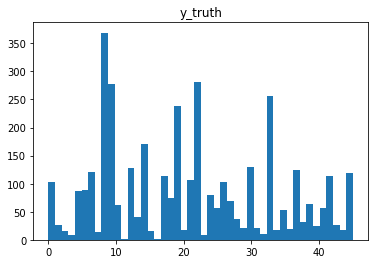

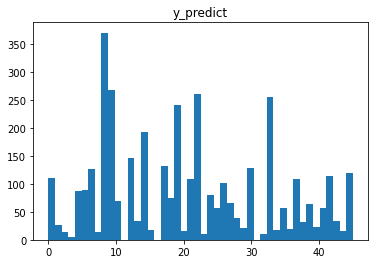

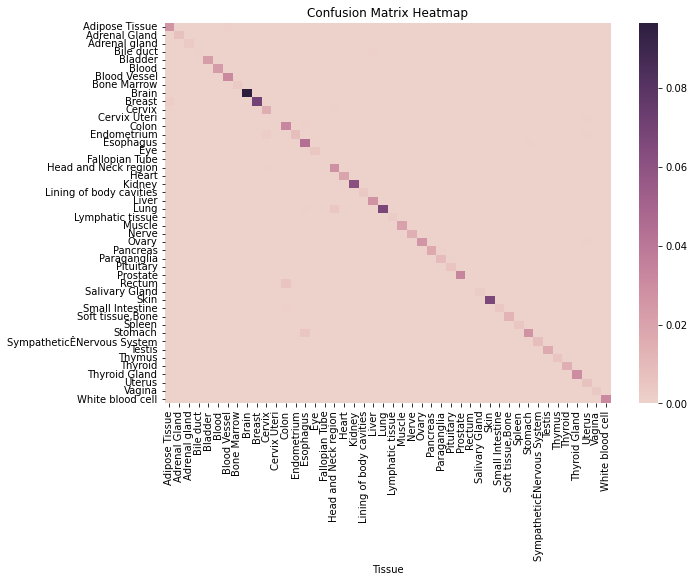

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


classification report:                              precision    recall  f1-score   support

            Adipose Tissue       0.92      0.98      0.95       103
             Adrenal Gland       0.96      1.00      0.98        26
             Adrenal gland       1.00      0.93      0.97        15
                 Bile duct       0.80      0.44      0.57         9
                   Bladder       0.98      0.98      0.98        87
                     Blood       1.00      1.00      1.00        89
              Blood Vessel       0.94      0.99      0.97       121
               Bone Marrow       1.00      1.00      1.00        14
                     Brain       1.00      1.00      1.00       369
                    Breast       1.00      0.96      0.98       278
                    Cervix       0.84      0.95      0.89        62
              Cervix Uteri       0.00      0.00      0.00         2
                     Colon       0.84      0.96      0.89       128
               Endometr

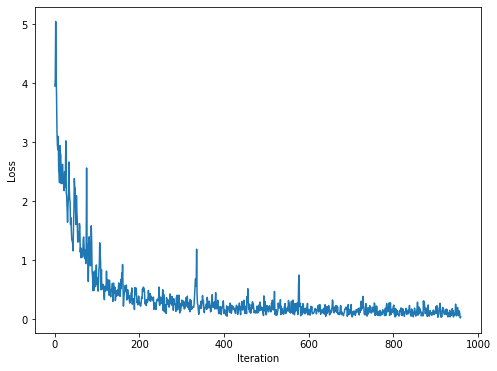

In [29]:
# print("y_predict: ", y_prediction)
# print("y_truth: ", y_truth)
argmax_y_true = np.argmax(y_truth, axis = 1)
argmax_y_predict = np.argmax(y_prediction.detach().numpy(), axis = 1)

print("argmax y true shape: ", argmax_y_true.shape)
print("argmax y predict shape: ", argmax_y_predict.shape)
print("argmax y true[0]: ", argmax_y_true[0])
print("argmax y predict[0]: ", argmax_y_predict[0])
# print("argmax y true: ", argmax_y_true)
# print("argmax y predict: ", argmax_y_predict)

matches = 0
for item in range(len(argmax_y_predict)):
  if argmax_y_predict[item] == argmax_y_true[item]:
    matches += 1

print("Accuracy: ", matches/len(argmax_y_predict))

%matplotlib inline  
# The above is required to display matplotlib in jupyter
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

n, bins, patches = plt.hist(argmax_y_true, bins=len(dataset_train[1][1]), density=0, cumulative=0)

plt.title('y_truth')

plt.show()
n, bins, patches = plt.hist(argmax_y_predict, bins=len(dataset_train[1][1]), density=0, cumulative=0)
plt.title('y_predict')
plt.show()

cM = confusion_matrix(argmax_y_true, argmax_y_predict, normalize='all')
# print("cM: ", cM)

labels = []
for k, v in y_index_key.items():
  labels.append(k)
df_cm = pd.DataFrame(cM, index = labels,
                  columns = labels)
plt.figure(figsize = (10,7))
# print("labels: ", labels)
plt.title('Confusion Matrix Heatmap')

sns.heatmap(df_cm, cmap=sns.cubehelix_palette(as_cmap=True), xticklabels=labels, yticklabels=labels)
plt.xlabel('Tissue')

plt.show()

from sklearn.metrics import classification_report
cR = classification_report(argmax_y_true, argmax_y_predict, target_names=labels)
print("classification report: ", cR)
plot_loss(losses)
# print("losses: ", losses)
# print("Final loss:", sum(losses[-100:])/100)  # report the loss # 0.020917454063892366 with batch_size = 8
# loss = 0.020898071601986885 with batch size 20
# print("y_predict end: ", y_predict)    #y_predict = [y1, y2, ... y46] (# of examples)


In [27]:
# Print information on the train and test datasets
# print(dataset_train.x_data)
print('Train datapoints: ', len(dataset_train))
print('Test datapoints: ', len(dataset_test))
print('Input features: ', len(dataset_train[1][0]))
print('Output classes: ', len(dataset_train[1][1]))

Train datapoints:  15300
Test datapoints:  3826
Input features:  5172
Output classes:  46


QUESTIONS:

Part 1: 
1. There are 15300 training examples in the dataset.
2. The proportion of the full dataset used for testing is 20%, this is because 15300 + 3826 = 19126 and 3826/19126 is around .2000 therefore it's a 20/80 split for testing/training.
3. There are 5172 gene expression values used as input to classify each sample in the dataset.
4. There are 46 types of tissue in the data labels.
5. The size of the output layer in the neural network should be 46 classes. These correspond to the 46 different tissue types.
6. The tissue types are given an index in the 'y_index_key' variable. This will allow me to decode the outputted index that refers to a tissue type.

Part 2:

2. Flowchart image: https://drive.google.com/file/d/16nz-k6c72B74vn98jPiyP2_farFY5km8/view?usp=share_link

Part 3:

2. y, y_predict : torch.Size([3826, 46]) torch.Size([3826, 46])
The y and y_predict are the same size, as intended. They are both [3826, 46]

3. Yes, my test set size from Part 1 is 3826 test examples so my y and y_predict both match my test set size from Part 1.


5. Both the argmax vectors have the same shape of: 
argmax y true shape:  torch.Size([3826])
argmax y predict shape:  (3826,)
Although my y_argmax and y_predict_argmax aren't the same. When comparing them to my table I made in #4, the first y_argmax and the first y_predict_argmax are different. These do not make a lot of sense since the y_predict_argmax should be the same as the y_argmax. The y_predict_argmax should match my truth set.

6. My classification accuracy is not very good. 
It is Accuracy:  0.04181913225300575 so it is around 4% accurate.

7. The argmax_y_predicted and argmax_y_true histograms are quite different. The argmax_y_true is more spread out while my argmax_y_predicted is centered around a specific class index (36). If my argmax_y_predicted had better predictions and was more accurate, it would better match the argmax_y_true histogram.


Part 5:

2. The data was processed with a different optimizer (SGD instead of Adam) and then my training parameters are 5 epochs, 80 for my batch size, and then 3000 for my first hidden layer, and 2000 for my second hidden layer. 

3. I'm getting a final accuracy of 0.9610559330893884 or 96%.

4. The tissues that were the most "confusing" for the model include Fallopian Tube and Cervix Uteri, which both had an F1 score (which takes into account precision and recall) of 0.0. Also, the rectum tissue had the lowest non-zero F1 score of .37. The closer to 1 the F1 score is, the better the model.

5. Each class's frequency correlates to the model's performance for that class quantitatively because the frequency is calculated based on the precision and recall. The precision of a class is the percentage of correct positive predictions relative to total positive predictions and the recall of a class is the percentage of correct positive predictions relative to total actual positives. So having a frequency between 0 and 1 that is calculated from the recall and precision makes it a qualitative analysis of the model's perfomance on prediction for that specific class.

6. A lot of trial and error went into choosing my hyperparameters. I mostly took into account the runtime and the accuracy when changing the hyperparameters. I messed a lot with batch size and the number of epochs. Moving these up and down were mostly to change the runtime of the program. The current batch size of 80 and the 5 epochs seem to give the most middle ground for efficiency. The hyperparameters of the model's hidden layers was where I had the most trial and error. Currently I have 2 hidden layers, the first being 3000 and the second being 2000. This seemed to be the smallest model I could create that would give me the best results for the time spent training. I tried 3 hidden layers and 1 hidden layer with varying sizes and it either took a long time to run with not much better results or it would run quickly but not train the model sufficiently. The way I evaluated if my hyperparameters were the best was simply comparing it to other hyperparameters I was using and choosing the hyperparameters that gave me the best accuracy from training the model paired with the amount of time it took for the program to run.

7. The total number of weight parameters you would be optimizing is 2304 because the input nodes multipled the hidden layer nodes is 2048 connections and then we add the hidden layer nodes multiplied by the output nodes which is 256. 2048 + 256 = 2304. The number of bias parameters is 68 which is from adding the number of hidden layer nodes to the number of output nodes. For my network, there are 21,608,000 weight parameters being optimized.. This is because I multiply my input nodes with my first hidden layer (5172 x 3000 = 15,516,000), then I multiply my hidden layer nodes together (3000 x 2000 = 6,000,000), and then I multiply my second hidden layer (the last hidden layer) with the number of output nodes (2000 x 46 = 92,000). Then I add all of these numbers together (15,516,000 + 6,000,000 + 92,000 = 21,608,000). This number of weight parameters in my network is a lot bigger than the number of training examples in my dataset (15,300). The number of weight parameters in my network is around 1412 times bigger than my training dataset.

8. There is a risk of overfitting but I don't believe that it is likely with the current parameters. If I added more hidden layers and ultimately created a bigger model, the risk of overfitting would definitely be more likely. The size of the test set makes me not super confident that this model will generalize to all future data I might encounter. Making the test set bigger would better ensure that it could generalize future data. 

9. There is most likely a better combination of hyperparameters with respect to the test results. I played around with the hyperparameters and these that I landed on seemed to be pretty good however, I believe more extensive testing could illustrate better hyperparameter choices all around. Some short comings are the number of epochs and batch size because I set the batch size somewhat high and the epochs relatively low. Increasing epochs and decreasing batch size would definitely yield a better model however the time it takes to run would dramatically increase. If I had infinite time and resources, I would add another hidden layer that was somewhat small and then I would increase the epochs to somewhere between 20-30 and then decrease batch size to somewhere between 20-50. This would create a better model but would take significantly longer.

10. The learning rate and the optimizer can affect this model's performance. I didn't play around with the learning rate all that much but I ended up switching the opitimizer from the torch.optim.Adam to torch.optim.SGD optimizer, which sped the whole program up. SGD probably isn't as good of an optimizer as Adam since it is quicker and I'm using a decently big-sized dataset, however for the purposes of testing it was the best choice in my opinion.

11. My model is separating the two "adrenal gland" labeled classes. This might indicate that my model has the ability to generalize new "adrenal gland" tissue types pretty well since it can separate the "adrenal gland" label when there are subtle differences. This is better for generalization since my model can differentiate between the two labels. I would need to test this on a new dataset with "adrenal gland" labels in it to calculate the effectiveness of my model for generalize of new data.